In [18]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
epsilon_0 = 8.85e-12

In [19]:
mesh = fn.Mesh('geo_charge.xml')
subdomains = fn.MeshFunction("size_t", mesh, 'geo_charge_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'geo_charge_facet_region.xml')

In [20]:
dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
V0 = fn.FunctionSpace(mesh, 'DG', 0)
V = fn.FunctionSpace(mesh, 'P', 2)

In [21]:
outer_boundary = fn.DirichletBC(V, fn.Constant(0), boundaries, 4)
bcs =[outer_boundary]

In [22]:
class rho(fn.UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 1:
            values[0] = 5
        else:
            values[0] = 0
    
        return 0

charge_density = rho(subdomains, degree=1)

In [23]:
# This is an alternative to making an expression

#rho = fn.Function(V0)
#
#for n, cell_no in enumerate(subdomains.array()):
#    subdomain_no = subdomains.array()[n]
#    if subdomain_no == 1:
#        value = 5
#    if subdomain_no == 2:
#        value = 0
#        
#    rho.vector()[n] = value

## Plot the charge density

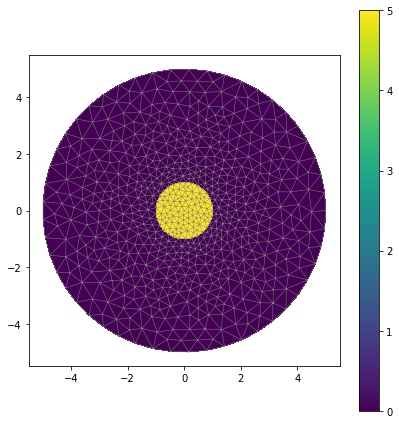

In [24]:
plt.figure(figsize=(6,6))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(fn.project(charge_density, V0))
plt.colorbar(p)
plt.tight_layout()
plt.savefig('images/charge_density.png', bbox_inches='tight')
plt.show()

## Solve the problem

In [25]:
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
a = fn.dot(fn.grad(u), fn.grad(v)) * epsilon_0 * fn.dx
L = charge_density * v * fn.dx
u = fn.Function(V)
fn.solve(a == L, u, bcs)

## Plot the electric potential distribution

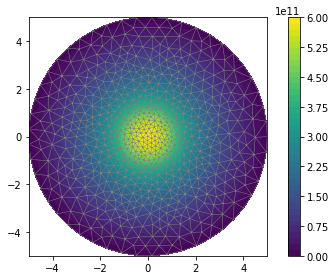

In [26]:
%matplotlib inline
plt.figure()
fn.plot(mesh, linewidth=0.5)
p = fn.plot(u)
plt.colorbar(p)
plt.tight_layout()
plt.savefig('images/electric_potential.png', bbox_inches='tight')
plt.show()

## Calculate and plot the electric field

In [27]:
electric_field = fn.project(-fn.grad(u))

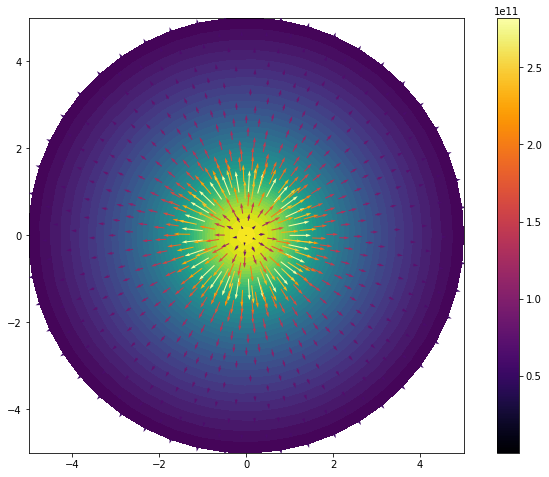

In [28]:
%matplotlib inline
plt.figure(figsize=(12,8))
# fn.plot(mesh, linewidth=0.5)
fn.plot(u)
p = fn.plot(electric_field, zorder=3, cmap='inferno')
plt.colorbar(p)
plt.savefig('images/electric_field.png', bbox_inches='tight')
plt.show()

## Evaluate the electric field along a line
plot the potential distribution with the line overlaid

In [29]:
lhs = np.linspace(-5, -1, 100)
in_r = np.linspace(-1, 1, 100)
rhs = np.linspace(1, 5, 100)

In [30]:
lhs = np.linspace(-4.9, -1, 100)
in_r = np.linspace(-1, 1, 100)
rhs = np.linspace(1, 4.9, 100)
x = np.hstack((lhs,in_r, rhs))

yc = np.zeros(len(x))
u_1 = np.array(list(map(u, zip(x, yc))))
e_field = np.array(list(map(electric_field, zip(x, yc))))

%matplotlib inline
plt.figure()
fn.plot(mesh, linewidth=0.5)
fn.plot(u)
plt.plot(x, yc)
plt.show()

## Plot the FEniCS solution overlaid with the analytical solution

In [31]:
def E_in(rho, r):
    return rho * r / 2 / epsilon_0

def E_out(rho, r, a):
    return rho * a**2 / 2 / epsilon_0 / r

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(x, e_field[:, 0], linewidth=3, label='FEniCS')
plt.plot(in_r, E_in(5, in_r), 'C1--', label='Analytical')
plt.plot(lhs, E_out(5, lhs, 1), 'C1--')
plt.plot(rhs, E_out(5, rhs, 1), 'C1--')
plt.xlabel("x-position")
plt.ylabel("Electric Field")
plt.grid()
plt.tight_layout()
plt.legend(loc=0)
plt.savefig('images/electric_field_comp.png', bbox_inches='tight')
plt.show()

## Plot the percentage difference

In [33]:
results = np.hstack((E_out(5, lhs, 1), E_in(5, in_r), E_out(5, rhs, 1)))
difference = (e_field[:, 0]-results)
percentage_difference = difference / e_field[:, 0] * 100

plt.figure(figsize=(12, 5))
plt.plot(x, percentage_difference, 'C1--', label='Analytical')
plt.xlabel("x-position")
plt.ylabel("Electric Field Percentage Difference")
plt.grid()
plt.tight_layout()
plt.legend(loc=0)
plt.savefig('images/electric_field_difference.png', bbox_inches='tight')
plt.show()

## Output to file

In [34]:
potentialFile = fn.File('output/potential.pvd')
potentialFile << u

vtkfile = fn.File('output/e_field.pvd')
vtkfile << electric_field